# Welcome to the Lab 🥼🧪
## Which markets have large institutions had the greatest impact on single family home resale listings? 

We will be reviewing 1000+ unit portfolios, specifically their impact on the single family home resale market. 

Welcome to the Lab - LFG

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY` as as secret. See this [guide](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) for more information.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-examples/blob/main/python/large_institutional_impact_on_resale_market.ipynb)

We will be making 👇

![Chart1](assets/percent_of_resale_market_by_1000_plus_unit_portfolios.png)

In [1]:
# Environment setup
import os
import sys
import subprocess
from datetime import datetime

# Collab setup from one click above
if "google.colab" in sys.modules:
    from google.colab import userdata
    %pip install parcllabs plotly kaleido
    api_key = userdata.get('PARCL_LABS_API_KEY')
else:
    api_key = os.getenv('PARCL_LABS_API_KEY')

In [2]:
import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.16


In [4]:
client = ParclLabsClient(api_key=api_key)

In [5]:
# lets get all metros in the country
metros = client.search_markets.retrieve(
    location_type='CBSA',
    as_dataframe=True,
    params={
        'limit': 1000
    }
)

In [7]:
# get the ids
metro_ids = metros['parcl_id'].tolist()

In [10]:
# get most recent housing stock for all metros
portfolio_resale = client.portfolio_metrics_new_listings_for_sale_rolling_counts.retrieve_many(
    parcl_ids=metro_ids,
    params={
        'limit': 1 # let's get the most recent stock
    },
    portfolio_size='PORTFOLIO_1000_PLUS',
    as_dataframe=True # make life easy on ourselves
)

|████████████████████████▊⚠︎              | (!) 575/927 [62%] in 2:34.3 (3.73/s) 


In [15]:
portfolio_resale.head()

,date,period,counts,pct_sf_for_sale_market,parcl_id,portfolio_size
0,2024-04-22,rolling_7_day,19.0,1.06,2900187,PORTFOLIO_1000_PLUS
1,2024-04-22,rolling_30_day,72.0,1.02,2900187,PORTFOLIO_1000_PLUS
2,2024-04-22,rolling_60_day,157.0,1.11,2900187,PORTFOLIO_1000_PLUS
3,2024-04-22,rolling_90_day,217.0,1.11,2900187,PORTFOLIO_1000_PLUS
4,2024-04-22,rolling_7_day,12.0,0.65,2900078,PORTFOLIO_1000_PLUS


In [18]:
# get 30 day rolling count
df = portfolio_resale.loc[(portfolio_resale['period']=='rolling_30_day')&(portfolio_resale['date']=='2024-04-22')][['parcl_id', 'date', 'counts', 'pct_sf_for_sale_market']]
df.head()

,parcl_id,date,counts,pct_sf_for_sale_market
1,2900187,2024-04-22,72.0,1.02
5,2900078,2024-04-22,50.0,0.70
9,2899845,2024-04-22,123.0,1.45
13,2899734,2024-04-22,254.0,1.89
17,2899967,2024-04-22,202.0,1.74


In [57]:
# merge Parcl data with rolling resale data
out = pd.merge(metros[['parcl_id', 'name']], df, on='parcl_id')
out = out.drop('parcl_id', axis=1)
out.head()

,name,date,counts,pct_sf_for_sale_market
0,"New York-Newark-Jersey City, Ny-Nj-Pa",2024-04-22,72.0,1.02
1,"Los Angeles-Long Beach-Anaheim, Ca",2024-04-22,50.0,0.70
2,"Chicago-Naperville-Elgin, Il-In-Wi",2024-04-22,123.0,1.45
3,"Dallas-Fort Worth-Arlington, Tx",2024-04-22,254.0,1.89
4,"Houston-The Woodlands-Sugar Land, Tx",2024-04-22,202.0,1.74


In [58]:
# filter out rows with less than 25 events, sort by percentage of market in descending order
out = out.loc[out['counts'] > 25].sort_values('pct_sf_for_sale_market', ascending=False).reset_index(drop=True)

In [59]:
# create function to format metro names
def format_names(nme):
    state = nme.split(',')[-1].strip()
    metro = nme.split(',')[0].split('-')[0].strip()
    metro = metro.split('/')[0].strip()
    return metro

labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white.png'
}

# set charting constants
labs_logo_dict = dict(
        source=labs_logo_lookup['white'],
        xref="paper",
        yref="paper",
        x=0.5,  # Centering the logo below the title
        y=1.02,  # Adjust this value to position the logo just below the title
        sizex=0.15, 
        sizey=0.15,
        xanchor="center",
        yanchor="bottom"
)

media_img_size_lookup = {
    'X': {
        'width': 1600,
        'height': 900
    }
}

PLATFORM = 'X'

# set image sizes
IMG_WIDTH = media_img_size_lookup[PLATFORM]['width']
IMG_HEIGHT = media_img_size_lookup[PLATFORM]['height']

# plotting title settings
PLOT_TITLE_SETTINGS = {
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }

# set default save directory
save_dir = './graphics'
new_dir_name = f"resale_1000_plus_units-metros-{datetime.today().date()}"
output_dir = os.path.join(save_dir, new_dir_name)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

out['name'] = out['name'].apply(lambda x: format_names(x))
out['pct_sf_for_sale_market'] = out['pct_sf_for_sale_market']/100 # format pct for charting

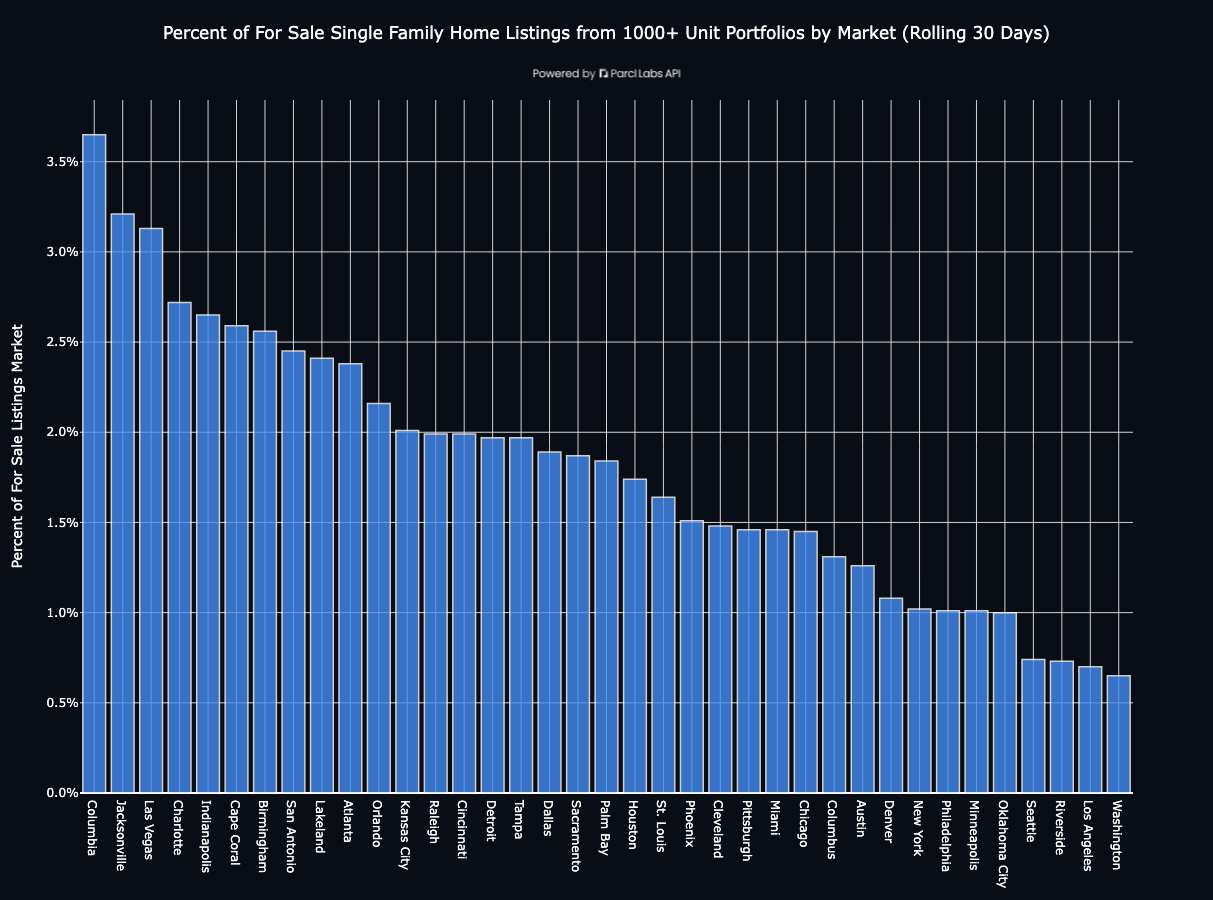

In [67]:
# Creating the horizontal bar chart
fig = px.bar(
    out, 
    y='pct_sf_for_sale_market',
    x='name', 
    orientation='v',
    title=f'Percent of For Sale Single Family Home Listings from 1000+ Unit Portfolios by Market (Rolling 30 Days)',
    labels={'percent': 'Percent of Single Family Homes'}
)

# Adding the logo as a layout_image
fig.add_layout_image(labs_logo_dict)

# Adjusting the layout
fig.update_layout(
    margin=dict(b=100),
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        xanchor='left',
        yanchor='top',
        title='Rolling Window (Days)'
    ),
    title=PLOT_TITLE_SETTINGS,
    plot_bgcolor='#080D16',
    paper_bgcolor='#080D16',
    font=dict(color='#FFFFFF'),
    yaxis_title='Percent of For Sale Listings Market',
    xaxis_title=None
)

# Bar color and other properties
fig.update_traces(
    marker_color='#448CF2',
    marker_line_color='#FFFFFF',
    marker_line_width=1.5,
    opacity=0.8
)

# Adding gridlines
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey', tickformat=".1%")
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

# Save the figure
fig.write_image(os.path.join(output_dir, 'percent_of_resale_market_by_1000_plus_unit_portfolios.png'), width=IMG_WIDTH, height=IMG_HEIGHT)

# Show the plot
fig.show()


In [65]:
# now lets simplify writing the text

for index, row in out.iterrows():
    rank = index+1
    name = row['name']
    count = int(row['counts'])
    pct = row['pct_sf_for_sale_market']
    msg = f"{rank}. {name}: {count} units, {round(pct*100, 1)}% of market"
    print(msg)

1. Columbia: 43 units, 3.6% of market
2. Jacksonville: 115 units, 3.2% of market
3. Las Vegas: 161 units, 3.1% of market
4. Charlotte: 114 units, 2.7% of market
5. Indianapolis: 76 units, 2.6% of market
6. Cape Coral: 55 units, 2.6% of market
7. Birmingham: 53 units, 2.6% of market
8. San Antonio: 113 units, 2.5% of market
9. Lakeland: 38 units, 2.4% of market
10. Atlanta: 294 units, 2.4% of market
11. Orlando: 92 units, 2.2% of market
12. Kansas City: 82 units, 2.0% of market
13. Raleigh: 39 units, 2.0% of market
14. Cincinnati: 54 units, 2.0% of market
15. Detroit: 113 units, 2.0% of market
16. Tampa: 120 units, 2.0% of market
17. Dallas: 254 units, 1.9% of market
18. Sacramento: 44 units, 1.9% of market
19. Palm Bay: 26 units, 1.8% of market
20. Houston: 202 units, 1.7% of market
21. St. Louis: 72 units, 1.6% of market
22. Phoenix: 110 units, 1.5% of market
23. Cleveland: 27 units, 1.5% of market
24. Pittsburgh: 29 units, 1.5% of market
25. Miami: 84 units, 1.5% of market
26. Chicag